In [1]:
### imports 
import pandas as pd
import seaborn as sns
import sys
import ast

sys.path.append('../')
sys.path.append('../src')

from src.datahandling.loading import load_data
from src.datahandling.preprocessing import *
from src.models.ma import MovingAverage
from src.models.regression import RidgeRegression
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem
# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")
benchmarks_braz = list(benchmarks["MAE"][3:]) + list(benchmarks["RMSE"][3:])
benchmarks_brit = list(benchmarks["MAE"][:3]) + list(benchmarks["RMSE"][:3])

# Evaluation - Notebook

Within this document, we carry out an assessment of the implemented models. We compare the following models:

1. Moving Average
2. Two Variants of Linear Regression
3. XGBoost

Please find the hyperparameter tuning and comments on the transfer learning challenge of the models in their respective notebook.

In [3]:
### define models
models = {
    "ma": Pipeline(
        [
            ("st", SupervisedTransformer()),
            ("ma", MovingAverage()),
        ]
    ),
    "rr": Pipeline(
        [
            ("scale", Normalizer()),
            ("st", SupervisedTransformer(encode_time=["hour", "month"])),
            ("est", RidgeRegression()),
        ]
    ),
    "kernel": Pipeline(
        [
            ("scale", Normalizer()),
            ("st", SupervisedTransformer(encode_time=["hour", "month"])),
            ("nystroem", Nystroem(n_jobs=-1)),
            ("est", RidgeRegression()),
        ]
    ),
}

## British Dataset - Kelmarsh

In [4]:
### loading data
TURBINE_ID = 2
data_brit = load_data(turbine_id=TURBINE_ID, which_data="British")

### cleaning data
cleaner = DataCleaner(
    features=[
        "Power (kW)",
        "Wind speed (m/s)",
        "Wind direction (°)",
        "Nacelle position (°)",
        "Nacelle ambient temperature (°C)",
        "Rotor speed (RPM)",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "nacelle_position",
        "nacelle_temp",
        "rotor_speed",
    ],
)
data_brit = cleaner.transform(data_brit)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_brit, test_start=test_start, test_end=test_end, target_var="power"
)

In [5]:
### load results and best parameters
gs_results = {}
best_params = {}

for key in models.keys():
    gs_results[key] = pd.read_csv(f"../results/results_gs_{key}_braz.csv")
    best_params[key] = (
        gs_results[key]
        .set_index(["params"])[["mean_test_score", "param_st__horizon"]]
        .groupby("param_st__horizon")
        .idxmax()
    )

In [6]:
### calculate metrics for each model and horizon
Metrics = ["MAE", "RMSE"]
Horizons = ["10min", "hourly", "daily"]
# create multiindex for results dataframe
idx = pd.MultiIndex.from_product([Metrics, Horizons], names=["Metric", "Horizon"])
results_brit = pd.DataFrame(index=idx, columns=models.keys())

for key in models.keys():
    print(key)
    for horizon in Horizons:
        # load best model for horizon
        best_model = models[key].set_params(
            **ast.literal_eval(best_params[key].loc[horizon][0])
        )
        # fit model
        best_model.fit(X_train, y_train)
        # predict
        y_pred = best_model.predict(X_test)
        # calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        # save results
        results_brit.loc[("MAE", horizon), key] = mae
        results_brit.loc[("RMSE", horizon), key] = rmse

ma
rr
kernel


/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


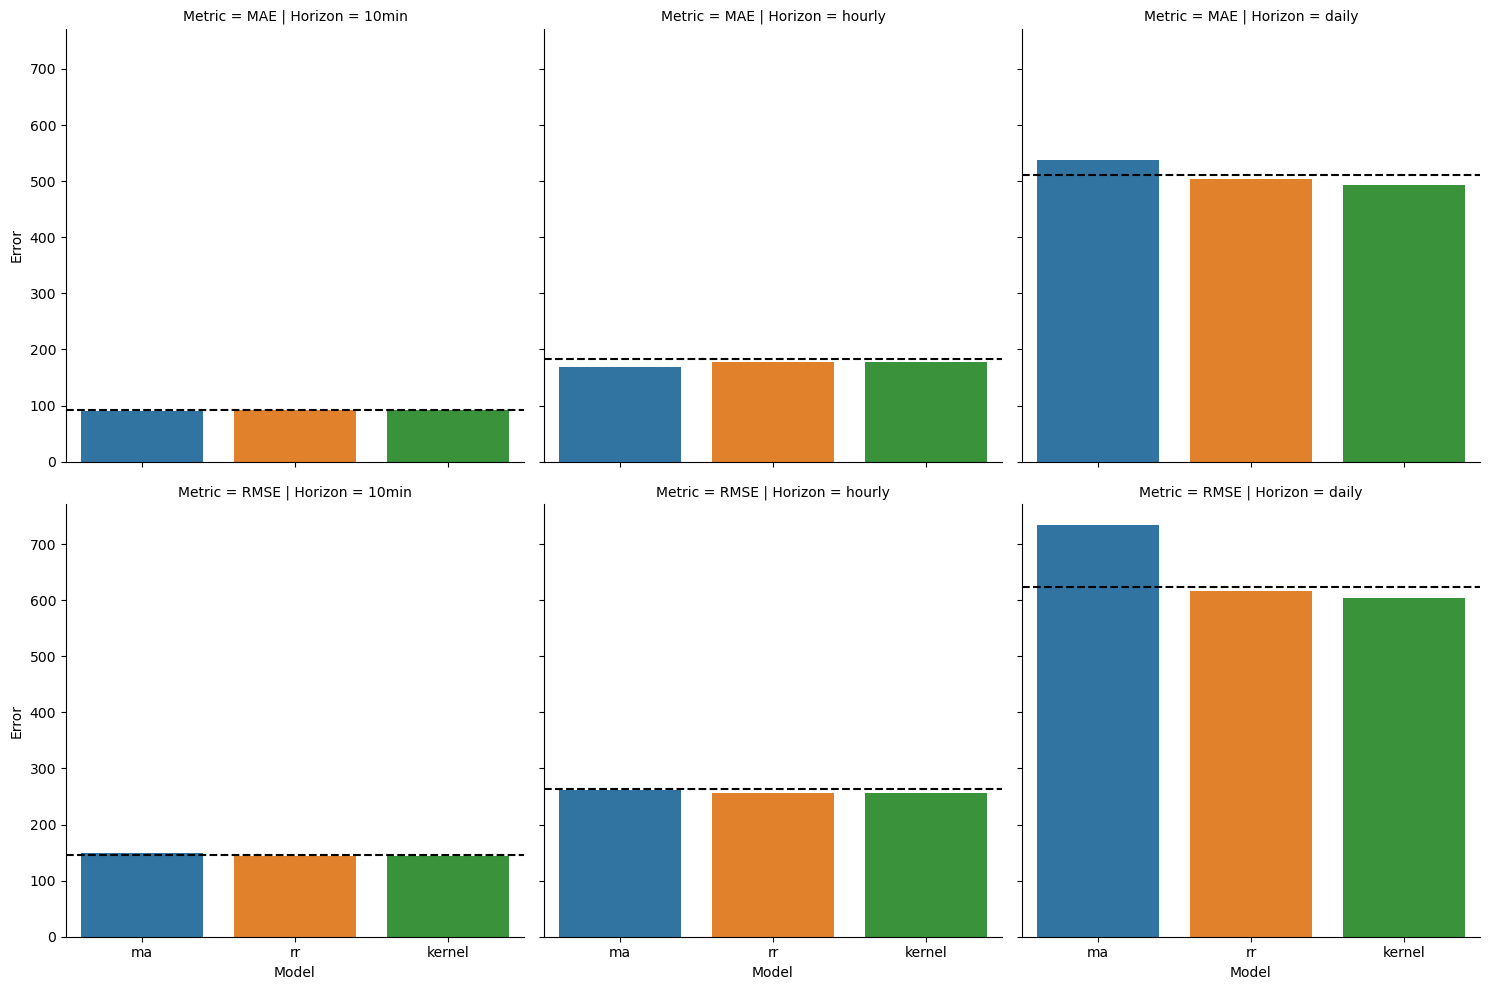

In [7]:
### plot results
df = pd.melt(
    results_brit.reset_index(),
    id_vars=["Metric", "Horizon"],
    value_vars=models.keys(),
    var_name="Model",
    value_name="Error",
)
fg = sns.catplot(df, x="Model", y="Error", col="Horizon", row="Metric", kind="bar")

for i, ax in enumerate(fg.axes.flat):
    ax.axhline(benchmarks_brit[i], ls="--", color="black")

__Analysis__:

Most models show superior performance compared to the benchmarks, with the exception being the _Moving Average_ model, which falls short when it comes to daily forecasting. The two regression variations exhibit comparable error rates, both slightly surpassing the benchmark in all cases.

In conclusion, we would advise considering the _Ridge Regression_ model as the top choice due to its computational efficiency and its ability to provide interpretable parameters. Furthermore, it demonstrates robustness with regard to its hyperparameters within this setting (see corresponding notebook).

## Brazilian Dataset - Beberibe

In [8]:
### loading data
TURBINE_ID = 1
data_braz = load_data(turbine_id=TURBINE_ID, which_data="Brazilian")

### cleaning data
cleaner = DataCleaner(
    features=[
        "active_power_total",
        "wind_speed",
        "wind_direction",
        "rotor_rpm",
        "air_density",
        "relative_humidity",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
        "air_density",
        "relative_humidity",
    ],
)
data_braz = cleaner.transform(data_braz)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][3]
test_end = benchmarks["test_end"][3]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_braz, test_start=test_start, test_end=test_end, target_var="power"
)

In [9]:
### load results and best parameters
gs_results = {}
best_params = {}

for key in models.keys():
    gs_results[key] = pd.read_csv(f"../results/results_gs_{key}_braz.csv")
    best_params[key] = (
        gs_results[key]
        .set_index(["params"])[["mean_test_score", "param_st__horizon"]]
        .groupby("param_st__horizon")
        .idxmax()
    )

In [10]:
### calculate metrics for each model and horizon
Metrics = ["MAE", "RMSE"]
Horizons = ["10min", "hourly", "daily"]
# create multiindex for results dataframe
idx = pd.MultiIndex.from_product([Metrics, Horizons], names=["Metric", "Horizon"])
results = pd.DataFrame(index=idx, columns=models.keys())

for key in models.keys():
    print(key)
    for horizon in Horizons:
        # load best model for horizon
        best_model = models[key].set_params(
            **ast.literal_eval(best_params[key].loc[horizon][0])
        )
        # fit model
        best_model.fit(X_train, y_train)
        # predict
        y_pred = best_model.predict(X_test)
        # calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        # save results
        results.loc[("MAE", horizon), key] = mae
        results.loc[("RMSE", horizon), key] = rmse

ma
rr
kernel


/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


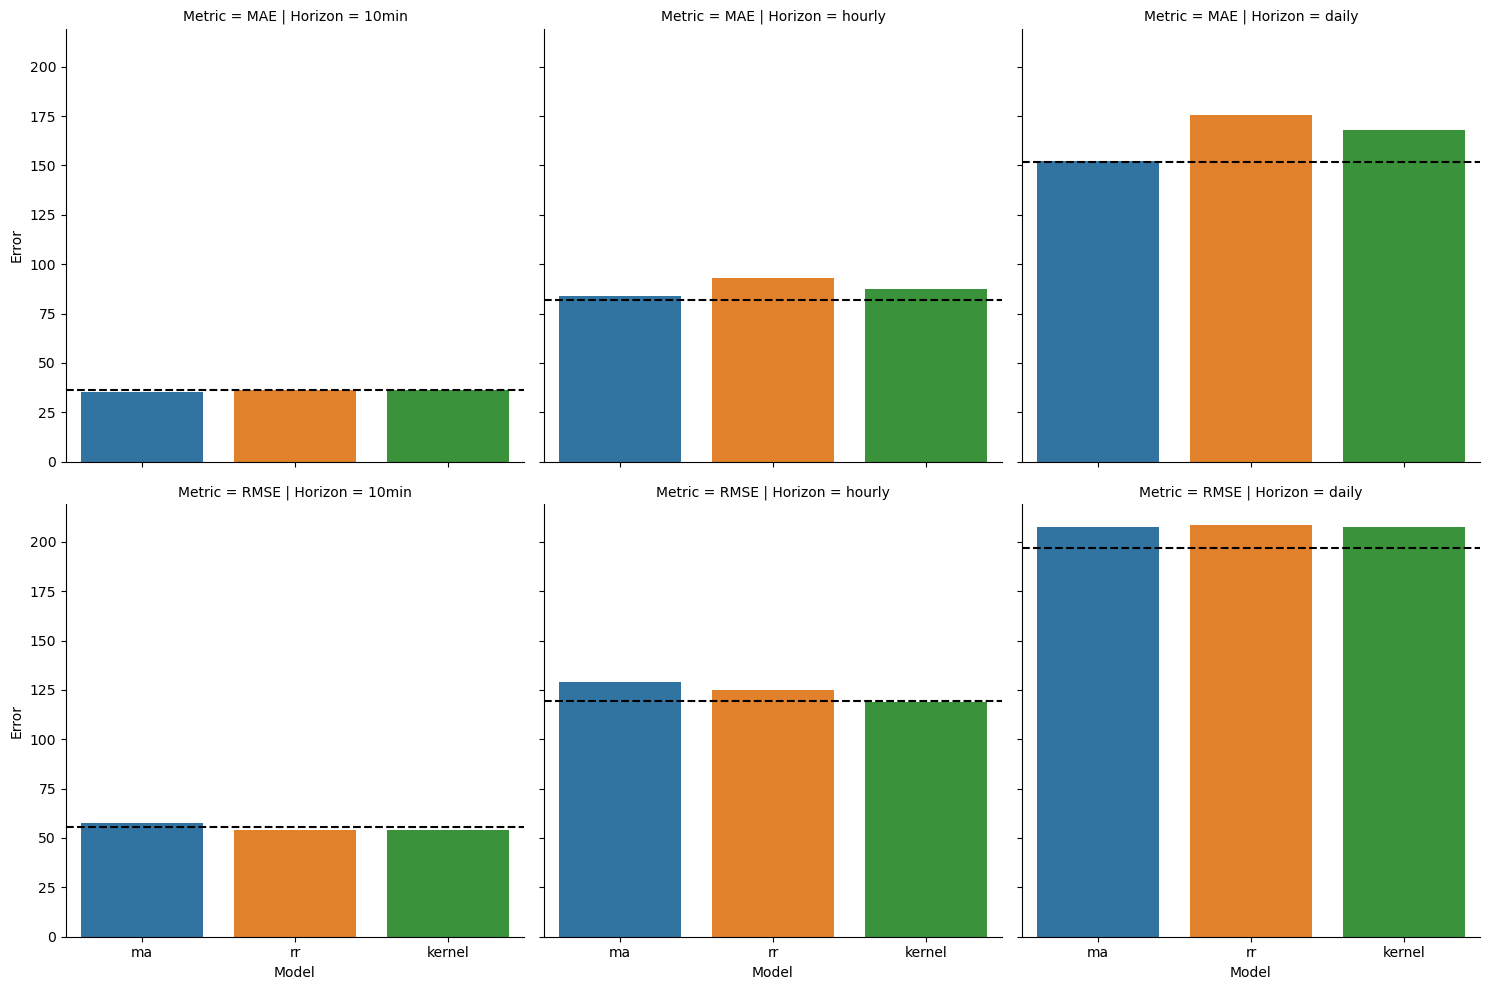

In [11]:
### plot results
df = pd.melt(
    results.reset_index(),
    id_vars=["Metric", "Horizon"],
    value_vars=models.keys(),
    var_name="Model",
    value_name="Error",
)
fg = sns.catplot(df, x="Model", y="Error", col="Horizon", row="Metric", kind="bar")

for i, ax in enumerate(fg.axes.flat):
    ax.axhline(benchmarks_braz[i], ls="--", color="black")

__Analysis__:


When compared to the British dataset, the models do not consistently outperform the benchmark in every instance. Furthermore, we do not observe a single model consistently outperforming the others. Interestingly, in certain scenarios, even the simplest model, the "Moving Average," outperforms the other models. This phenomenon may arise from the high periodicity present in the Brazilian dataset, from which the "Moving Average" model can benefit when tackling daily forecasting challenges.

Overall, the _Kernel Regression_ model seems to be the most promising model. However, it is also the most computationally expensive model, which may be a limiting factor in certain applications. Furthermore, it suffers from a lack of interpretability. 


# Overall Summary:

In this project, we have implemented and evaluated four different models for time series forecasting of the power output of a wind turbine. Datasets of a British and Brazilian wind farm were discussed. 

Using the same __implementation__ scheme as the estimators in sklearn yielded compatibility with the pipeline and grid search functionality of sklearn. This allowed us to perform hyperparameter tuning and cross-validation in a straightforward manner.

The __Moving Average__ model is the simplest model implemented. It just considers past values of the target variable to predict into the future. It is therefore computationally cheap and easy to interpret. However, it suffers from a strong time lag in its predictions. 
The __Ridge Regression__ model is also a computationally cheap model. It provides interpretable parameters and seems to be very robust with regard to its hyperparameters. 
__Kernel Regression__ and __XG Boost__ are computationally much more costly than the previous two. Nevertheless, they do not show a significant improvement in performance. That is why, having Occams Razor in mind, we would advise against using them in this setting.
Overall, __Ridge Regression__ seems to be the best choice for the given task.


For the __transfer learning challenge__ the trick seems to be to normalize every feature and targets to make them comparable across datasets. 